In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import sparse
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [1012]:
array_shape = (4,4)
telescope_number = np.prod(array_shape)
telescope_array = np.arange(telescope_number).reshape(array_shape)
tele_pos = [np.array(np.unravel_index(i, array_shape)) for i in range(telescope_number)]

In [1013]:
corners_idnx = np.ix_((0,-1), (0,-1))
corners = telescope_array[corners_idnx].flatten()

In [1014]:
tpx, tpy = np.meshgrid(np.arange(array_shape[0]-1),np.arange(array_shape[0]-1))
tleft = np.array(list(zip(tpx.flatten(), tpy.flatten())))
bpx, bpy = np.meshgrid(np.arange(1, array_shape[0]),np.arange(array_shape[0]-1))
bleft = np.array(list(zip(bpx.flatten(), bpy.flatten())))

In [1015]:
def get_baseline_key(i1, i2, shape=array_shape):
    p1 = np.array(np.unravel_index(i1, shape))
    p2 = np.array(np.unravel_index(i2, shape))
    pos_diff = p1 - p2
    sign = np.product(pos_diff)
    if sign > 0:
        key = tuple(np.abs(pos_diff))
    else:
        key = tuple((np.abs(pos_diff[0]), -1*np.abs(pos_diff[1])))
    return key

In [1016]:
def get_num_baselines(tele_num=telescope_number):
    # For square of N telescopes, should be 2N-2*sqrt(N) + 1
    # Fix to a corner and there are N-1 options for unique baselines. 
    # Flip over to other side (over x or y axis) and get another N-1 options
    # Duplicated are the pure x-axis and pure y-axis so -2*(sqrt(N)-1)
    # Final +1 is from 0 baseline
    
    N_bases = 2*tele_num - 2*np.sqrt(tele_num)
    return int(N_bases)

In [1017]:
def get_baselines_np(tele_num=telescope_number):
    base_size = get_num_baselines(tele_num)
#     redundant_baselines = sparse.dok_matrix((base_size, tele_num, tele_num))
    redundant_baselines = np.zeros((base_size, tele_num, tele_num))
    baseline_indx = []
    for i in range(tele_num):
        for k in range(tele_num):
            if i==k:
                continue
            key = get_baseline_key(i,k)
            if key in baseline_indx:
                red_indx = baseline_indx.index(key)
                redundant_baselines[red_indx][i,k] = 1
            else:
                baseline_indx.append(key)
                redundant_baselines[len(baseline_indx)-1][i,k] = 1
    return redundant_baselines, baseline_indx

In [1018]:
redundant_baselines, baseline_indx = get_baselines_np()
n_bases = get_num_baselines(telescope_number)

In [1019]:
def get_baseline_indx(i1, i2, base_idx = baseline_indx):
    key = get_baseline_key(i1, i2)
    return base_idx.index(key)

In [1070]:
rand_phases = lambda x: np.random.uniform(0, np.pi, x)

In [1071]:
npcb = np.vectorize(pow)

In [1072]:
def make_gains(tele_num=telescope_number):
    gain_amp = np.abs(np.random.normal(1, .3, tele_num))
    gain_phase = rand_phases(tele_num)
    tgain = gain_amp*np.exp(1j*gain_phase)
    return tgain, gain_phase

In [1073]:
def make_visibilities(tele_num=telescope_number):
    n_bases = get_num_baselines(telescope_number)
    sky_phase = rand_phases(n_bases)
    correl_sky = np.random.normal(3, .8, n_bases)*np.exp(1j*sky_phase)
    return correl_sky, sky_phase

In [1074]:
def make_uv_points(tg, va, tele_num=telescope_number):
    observation_baselines = np.zeros((tele_num, tele_num), dtype=np.complex128)
    unsym_noise = np.random.normal(.01, .005, (tele_num, tele_num))*np.exp(1j*rand_phases((tele_num, tele_num)))
    noise_matrix = (unsym_noise + unsym_noise.T)*.5
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            key = get_baseline_key(i, k)
            red_indx = baseline_indx.index(key)
            if i < k:
                vaterm = va[red_indx]
                noise = noise_matrix[i,k]
            else:
                vaterm = np.conj(va[red_indx])
                noise = np.conj(noise_matrix[i,k])
            sig = tg[i]*np.conj(tg[k])*vaterm
            observation_baselines[i,k] = sig+noise
    return observation_baselines, noise_matrix

In [1075]:
tgain, gain_phase = make_gains()
valpha, v_phase = make_visibilities()

In [1076]:
observation_baselines, noises = make_uv_points(tgain, valpha)

In [1077]:
snr = np.mean(np.abs(valpha)/np.mean(np.abs(noises)))
print("SNR is %f" % snr)

SNR is 403.802289


In [1078]:
def insert_internal_neighbors():
    for a in telescope_array:
        i,j,k,l = a
        numer = (observation_baselines[i,j]*observation_baselines[j,l])
        denom = (observation_baselines[i,k]*observation_baselines[k,l])
        sjk = np.abs(np.sqrt(numer/denom))
        scale_array[j,k] = sjk
        scale_array[k,j] = 1/sjk
    for a in telescope_array.T:
        i,j,k,l = a
        numer = (observation_baselines[i,j]*observation_baselines[j,l])
        denom = (observation_baselines[i,k]*observation_baselines[k,l])
        sjk = np.abs(np.sqrt(numer/denom))
        scale_array[j,k] = sjk
        scale_array[k,j] = 1/sjk

In [1079]:
def get_alpha1(a1, a2, a3):
    first_baseline = get_baseline_key(a1, a2)
    second_baseline = get_baseline_key(a2, a3)
    if first_baseline==baseline_indx[0]:
        term1 = observation_baselines[a1, a2]/observation_baselines[a2,a3]
        term2 = 1/(scale_array[a1, a2]*scale_array[a2, a3])
        alpha = term1*term2
    else:
        term1 = observation_baselines[a2, a3]/observation_baselines[a1,a2]
        term2 = (scale_array[a2,a3]*scale_array[a1,a2])
        alpha = term1*term2
    return np.abs(alpha)

In [1080]:
def get_avg_alpha():
    a1 = get_alpha1(5,6,10)
    a2 = get_alpha1(6,5,9)
    a3 = get_alpha1(6,10,9)
    a4 = get_alpha1(5,9,10)
    avg = (a1+a2+a3+a4)/4
    return avg

In [1081]:
def get_diagonal_connections(alpha):
    c1 = np.array([0,0])
    c12 = np.array([-2,-2])
    c2 = np.array([-1, 0])
    c22 = np.array([1, -2])
    
    for k in tleft:
        topleft = telescope_array[tuple(k)]
        nextright = telescope_array[tuple(k + [0,1])]
        diagonal = telescope_array[tuple(k+1)]
        term1 = observation_baselines[topleft, nextright]/observation_baselines[nextright, diagonal]
        term2 = 1/alpha
        sjk = np.abs(term1*term2)
        scale_array[topleft, diagonal] = sjk
        scale_array[diagonal, topleft] = 1/sjk
        
    for k in bleft:
        bottomleft = telescope_array[tuple(k)]
        nextright = telescope_array[tuple(k + [0,1])]
        diagonal = telescope_array[tuple(k + [-1,1])]
        term1 = observation_baselines[bottomleft, nextright]/observation_baselines[nextright, diagonal]
        term2 = 1/alpha
        sjk = np.abs(term1*term2)
        scale_array[bottomleft, diagonal] = sjk
        scale_array[diagonal, bottomleft] = 1/sjk
        
        

In [1082]:
def iterate_scales(scal, n=1):
    new_scales = scal.copy()
    for i in range(new_scales.shape[0]):
        for k in range(new_scales.shape[1]):
            vals = new_scales[i,:]*new_scales[:,k]
            if np.sum(vals) > 0:  
                avg_val = np.mean(vals[vals.nonzero()[0]])
                new_scales[i,k] = avg_val
                new_scales[k,i] = 1/avg_val
    return new_scales

In [1083]:
def true_gain_scale(tgain):
    tscale = np.zeros((telescope_number, telescope_number))
    for i in range(telescope_number):
        for k in range(telescope_number):
            val = np.abs(tgain[i]/tgain[k])
            tscale[i,k] = val
            tscale[k,i] = 1/val
    return tscale

In [1084]:
def get_valpha_ratio(i,j,k,l, gain_scale):
    term1 = np.abs(observation_baselines[i,j]/observation_baselines[k,l])
    term2 = 1/(gain_scale[i,k]*gain_scale[j,l])
    ratio = np.abs(term1*term2)
    return ratio

In [1085]:
def solve_valpha_sparse(gains, num_rando):
    vscale_array = np.diag(np.ones(n_bases))
    weight_array = np.zeros((n_bases, n_bases))
    vfin = np.diag(np.ones(n_bases))
    rng = np.random.default_rng()
    for n in tqdm(range(num_rando)):
        pos = rng.choice(16, 4, replace=False)
        k1 = get_baseline_indx(pos[0], pos[1])
        k2 = get_baseline_indx(pos[2], pos[3])
        if k1==k2:
            continue
        else:
            ratio = get_valpha_ratio(*pos, gains)
            if k1 > k2:
                vscale_array[k1, k2] += ratio
                weight_array[k1, k2] += 1
            else:
                vscale_array[k2, k1] += 1/ratio
                weight_array[k2, k1] += 1
            
    for i in range(n_bases):
        for k in range(i):
            if vscale_array[i,k]!= 0:
                avg_val = vscale_array[i,k]/weight_array[i,k]
                vfin[i,k] = avg_val
                vfin[k,i] = 1/avg_val
    return vfin

In [1086]:
def true_v_scales(valpha):
    varray = np.zeros((n_bases, n_bases))
    for i in range(n_bases):
        for k in range(n_bases):
            val = np.abs(valpha[i]/valpha[k])
            varray[i,k] = val
            varray[k,k] = 1/val
    return varray

In [1087]:
def create_estimate(gvec, alphas):
    false_obs = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            else:
                key = get_baseline_indx(i,k)
                false_obs[i,k] = gvec[i]*np.conj(gvec[k])*alphas[key]
    return false_obs

In [1088]:
def solve_amplitudes_gdgen_nosigma(gscales, observations, degen=telescope_number, fix_indx=10):
    solved_alphas = np.zeros(n_bases)
    weighted_alphas = np.zeros(n_bases)
    g1_abs = degen/np.sum(gscales[:,fix_indx])
    gain_vec = g1_abs*gscales[:,fix_indx]
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            else:
                key = get_baseline_indx(i,k)
                lhs = np.abs(observations[i,k])
                rhs = gain_vec[i]*gain_vec[k]
                val = lhs/rhs
                solved_alphas[key] += val
                weighted_alphas[key] += 1
                
    final_alphas = solved_alphas/weighted_alphas
    return final_alphas

In [1089]:
def logarithmic_ratio_random(observations, num=1000):
    rng = np.random.default_rng()
    total_variables = telescope_number + n_bases
    real_matrix = np.zeros((num, total_variables))
    imag_matrix = np.zeros((num, total_variables))
    lhs_real = np.zeros(num)
    lhs_imag = np.zeros(num)
    for n in tqdm(range(num)):
        i,j,k,l = rng.choice(16, 4, replace=False)
        lhs = (observations[i,j]/observations[k,l])
        lnlhs = np.log(lhs)
        lhs_real[n] = lnlhs.real
        lhs_imag[n] = lnlhs.imag
        alpha = telescope_number + get_baseline_indx(i,j)
        beta = telescope_number + get_baseline_indx(k,l)
        real_matrix[[n,n,n], [i,j,alpha]] = 1
        real_matrix[[n,n,n], [k,l,beta]] = -1
        imag_matrix[[n,n,n], [i,alpha, l]] = 1
        imag_matrix[[n,n,n], [j,k,beta]] = -1
    amps = sparse.linalg.lsqr(real_matrix, lhs_real)[0]
    phases = sparse.linalg.lsqr(imag_matrix, lhs_imag)[0]
    return amps, phases

In [1090]:
amps, phases = logarithmic_ratio_random(observation_baselines, 1000)

In [1091]:
tgr = np.log(tgain).real
tgp = np.log(tgain).imag

In [1092]:
tgp - phases[0:16]

array([2.07105753, 0.46394906, 0.35522115, 0.36926951, 3.32917443,
       2.51445916, 0.76683661, 2.87771019, 2.58923002, 1.41253304,
       2.59264789, 0.52230484, 2.39562098, 0.17894749, 0.28614023,
       0.10758183])

In [1093]:
tgr - amps[0:16]

array([0.13207189, 0.12537781, 0.13634195, 0.13290718, 0.12645948,
       0.13577179, 0.13049413, 0.12800238, 0.13041229, 0.13855282,
       0.13628749, 0.12939856, 0.13400644, 0.1333275 , 0.12950738,
       0.13033284])

In [1094]:
scale_array = np.diag(np.ones(telescope_number))
vscale_array = np.diag(np.ones(n_bases))
insert_internal_neighbors()

In [1095]:
alpha1 = get_avg_alpha()

In [1096]:
get_diagonal_connections(alpha1)

In [1097]:
fin_scal = iterate_scales(scale_array)
tscale = true_scale(tgain)

In [1098]:
vsparse = solve_valpha_sparse(fin_scal, 1000)

In [1099]:
sigma_scale = iterate_scales(vsparse)
true_sigma = true_v_scales(valpha)

In [1100]:
gdegen= 1
findx = 0

In [1101]:
g1_abs = gdegen/np.sum(fin_scal[:,findx])
gain_vec = g1_abs*fin_scal[:,findx]

In [1102]:
solved_alphas = solve_amplitudes_gdgen_nosigma(fin_scal, observation_baselines, degen=gdegen, fix_indx=findx)

Text(0.5, 1.0, 'Scaled $V_\\alpha$ Amplitude')

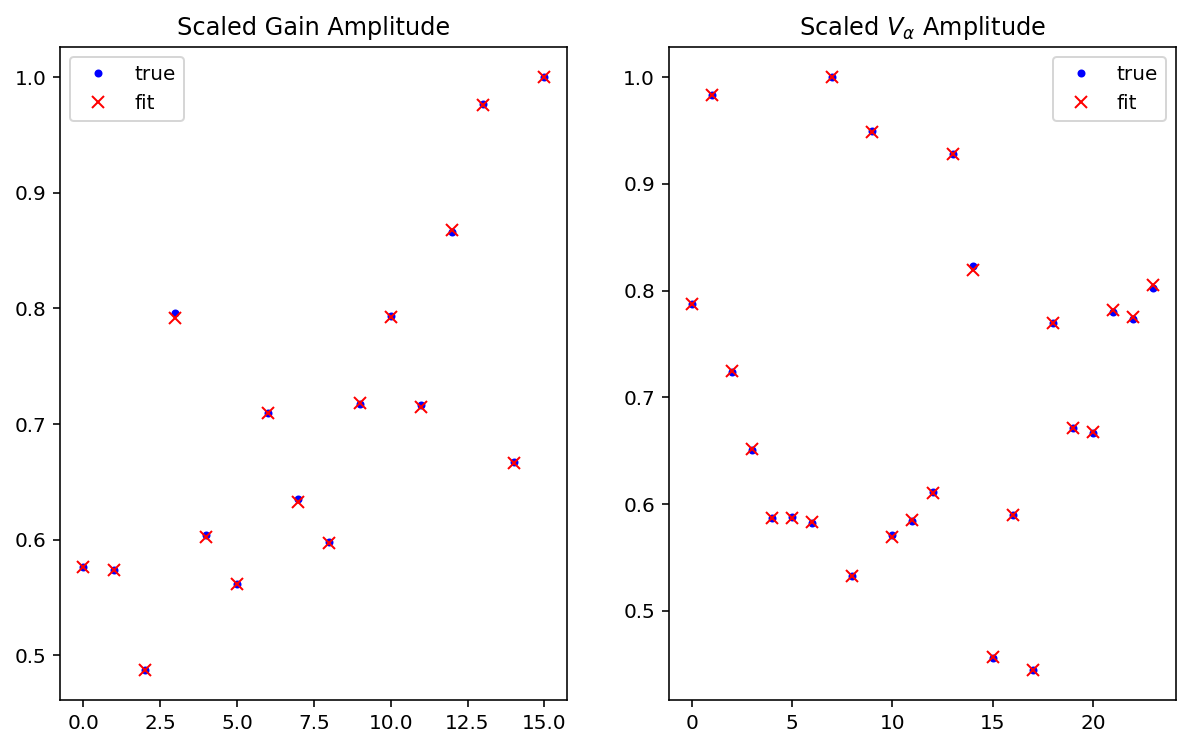

In [1103]:
fig, axs = plt.subplots(ncols=2, figsize=(10,6))

axs[0].plot(np.abs(tgain)/np.max(np.abs(tgain)), 'b.', label='true')
axs[0].plot(np.abs(gain_vec)/np.max(np.abs(gain_vec)), 'rx', label='fit')
axs[0].legend()
axs[0].set_title("Scaled Gain Amplitude")

axs[1].plot(np.abs(valpha)/np.max(np.abs(valpha)), 'b.', label='true')
axs[1].plot(np.abs(solved_alphas)/np.max(np.abs(solved_alphas)), 'rx', label='fit')
axs[1].legend()
axs[1].set_title(r"Scaled $V_\alpha$ Amplitude")

In [1104]:
false_yij = create_estimate(gain_vec, solved_alphas)

Average gain difference is 0.000011 
Average V_alpha difference is 0.005059 
Average estimate difference is -0.000134


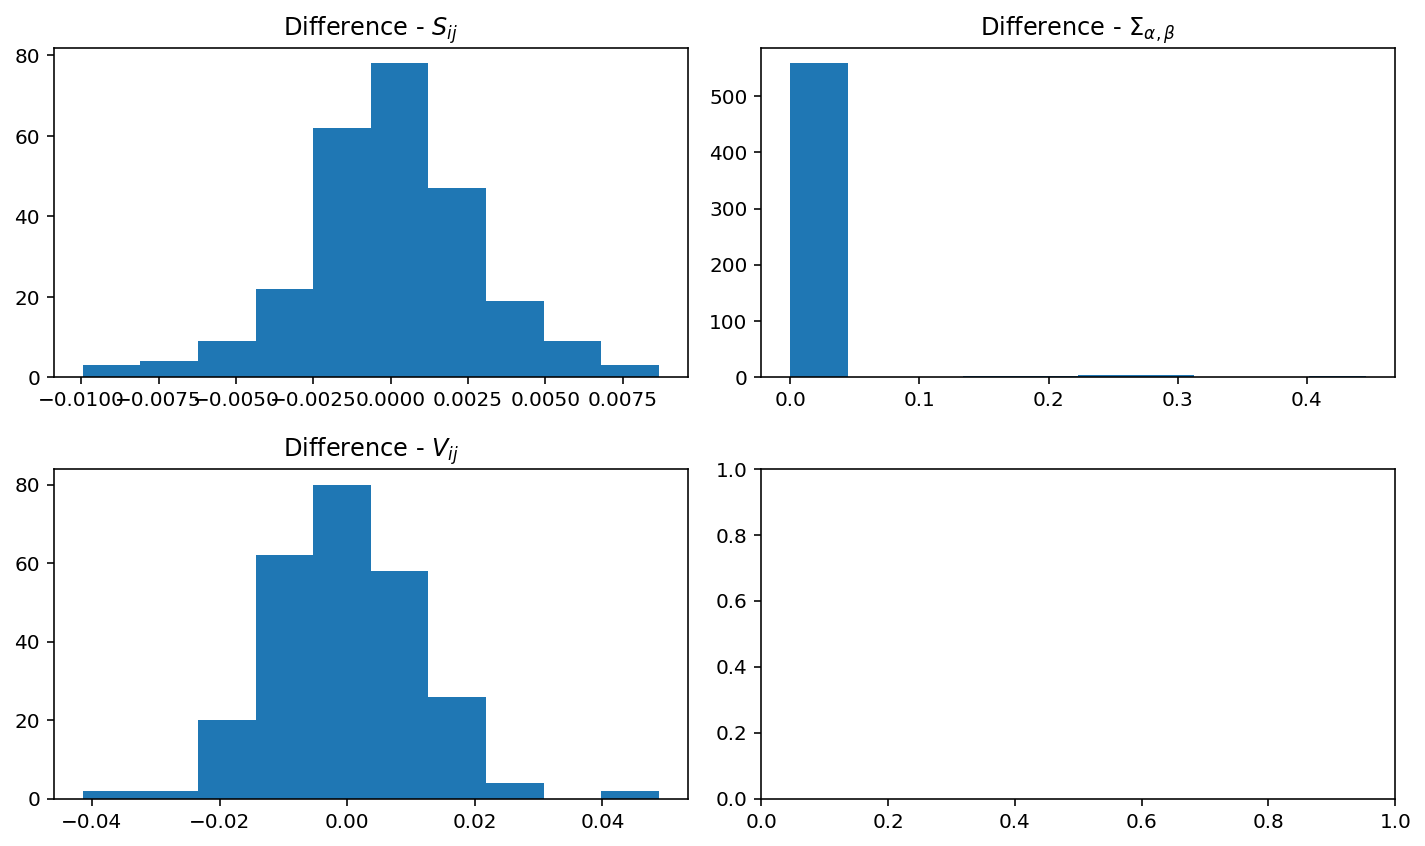

In [1105]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

ax[0,0].hist((fin_scal - tscale).flatten());
ax[0,0].set_title(r"Difference - $S_{ij}$")

ax[0,1].hist(np.abs((sigma_scale - true_sigma).flatten()));
ax[0,1].set_title(r"Difference - $\Sigma_{\alpha,\beta}$")

ax[1,0].hist((np.abs(observation_baselines) - false_yij).flatten().real);
ax[1,0].set_title(r"Difference - $V_{ij}$")

plt.tight_layout()

print("Average gain difference is %f " % np.mean(fin_scal - tscale))
print("Average V_alpha difference is %f " % np.mean(sigma_scale - true_sigma))
print("Average estimate difference is %f" % np.mean((np.abs(observation_baselines) - false_yij).real))

In [1106]:
telescope_array

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [1153]:
m1 = np.log(valpha[4]/np.conj(valpha[4]))

In [1168]:
a,b,c,d,e = [1,4,5,6,9]

In [1175]:
V = observation_baselines

In [1176]:
lhs1 = (V[a,c] * V[e,b])/(V[e,c]*V[a,b])

In [1178]:
lhs2 = (V[a,c] * V[e,d])/(V[e,c]*V[a,d])

In [1183]:
vbeta = valpha[3]

In [1184]:
rhs = np.sqrt(lhs2*lhs1)

In [1205]:
eta_k = np.abs(lhs1/lhs2)

In [1208]:
np.log(lhs2*eta_k)

(0.24666785550890755-1.7335897260296453j)

In [1209]:
np.log(lhs1/eta_k)

(-0.256256251114079-1.735438817544414j)

In [1187]:
m2 = np.log(rhs)

In [1193]:
np.log(vbeta/np.conj(vbeta)).imag

2.8893420071380103

In [1197]:
m2.imag

1.4070783818027637

In [1200]:
np.abs(3j)

3.0